# Building Predictive model for Insurance Claim Data

##1. Import Libraries

In [1]:
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

##2. Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Insurance_data = pd.read_csv('/content/drive/MyDrive/Train_data.csv')

##3. Understand the data

In [4]:
Insurance_data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [5]:
Insurance_data.shape

(7160, 14)

Finding: There are 7160 columns and 14 rows

In [6]:
Insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


Insight: 'Garden' column, 'Building dimension' column, 'Date of occupancy' column and 'Geo code' column have missing values

In [7]:
Insurance_data.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [8]:
Insurance_data.isnull().sum()

,0
Customer Id,0
YearOfObservation,0
Insured_Period,0
Residential,0
Building_Painted,0
Building_Fenced,0
Garden,7
Settlement,0
Building Dimension,106
Building_Type,0


In [9]:
Insurance_data.duplicated().sum()

np.int64(0)

Insight: There are no duplicate rows

In [10]:
Insurance_data['Claim'].value_counts(normalize=True)

,proportion
Claim,
0,0.771788
1,0.228212


###Insight

- Target variable Claim is binary
- This also shows an imbalanced dataset (Hence, recall & ROC-AUC become important)

##4. Data Cleaning

### Converting data type in 'NumberOfWindows' column and replacing the character '.' with NaN

In [11]:
# Replace '.' with NaN in 'NumberOfWindows' column
Insurance_data['NumberOfWindows'] = Insurance_data['NumberOfWindows'].replace('.', np.nan)

# Convert 'NumberOfWindows' to numeric type, using errors='coerce' to turn any values that cannot be converted into NaN
Insurance_data['NumberOfWindows'] = pd.to_numeric(Insurance_data['NumberOfWindows'], errors='coerce')

###Replacing missing values first in 'number of windows' column, then in other columns

In [12]:
# Impute missing values (NaN) in 'NumberOfWindows' with the median
Insurance_data['NumberOfWindows'].fillna(Insurance_data['NumberOfWindows'].median(), inplace=True)

# Convert to integer type after imputation, as number of windows should be whole numbers
Insurance_data['NumberOfWindows'] = Insurance_data['NumberOfWindows'].astype(int)

print("\n'NumberOfWindows' info after cleaning:")
Insurance_data.info()


'NumberOfWindows' info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   int64  
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 783.3+ KB


/tmp/ipython-input-3875192474.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Insurance_data['NumberOfWindows'].fillna(Insurance_data['NumberOfWindows'].median(), inplace=True)


In [13]:
num_cols = Insurance_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = Insurance_data.select_dtypes(include=['object']).columns

for col in num_cols:
    Insurance_data[col].fillna(Insurance_data[col].median(), inplace=True)

for col in cat_cols:
    Insurance_data[col].fillna(Insurance_data[col].mode()[0], inplace=True)

/tmp/ipython-input-279266036.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Insurance_data[col].fillna(Insurance_data[col].median(), inplace=True)
/tmp/ipython-input-279266036.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [14]:
Insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7160 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7160 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   7160 non-null   float64
 11  NumberOfWindows     7160 non-null   int64  
 12  Geo_Code            7160 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 783.3+ KB


Insight: This shows a dataset without any missing value

In [15]:
Insurance_data.head()


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,4,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,4,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,4,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


##5. Feature Engineering

In [16]:
# Creating a 'building_age' column
Insurance_data['Building_Age'] = Insurance_data['YearOfObservation'] - Insurance_data['Date_of_Occupancy']
Insurance_data['Building_Age'] = Insurance_data['Building_Age'].astype(int)

In [17]:
Insurance_data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,Building_Age
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,4,1053,0,53
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0,165
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,4,1053,0,54
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,4,1053,0,53
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0,214


In [18]:
# Dropping Unneccessary columns such as 'Customer Id' and 'Date_of_Occupancy' columns
Insurance_data = Insurance_data.drop(['Customer Id', 'Date_of_Occupancy'], axis=1)

##6. Exploratory Data Analysis

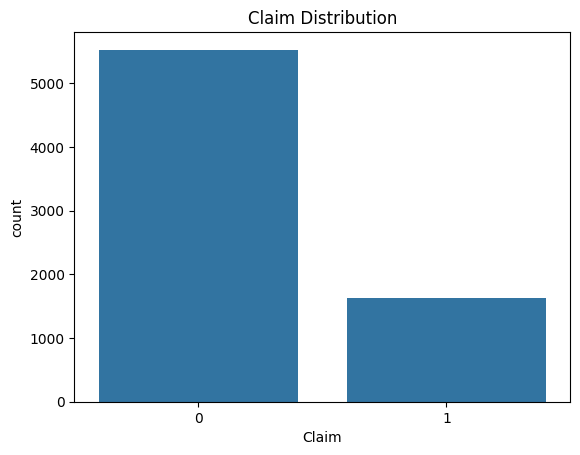

In [19]:
#Target Distribution
sns.countplot(x='Claim', data=Insurance_data)
plt.title("Claim Distribution");

In [20]:
Insurance_data['Claim'].value_counts()

,count
Claim,
0,5526
1,1634


Insight: This shows that a greater number 0f building has no claim over insured period (5526).
1634 of the building has at least a claim over the insured period.

In [21]:
#Claim Rate by Settlement Type
Insurance_data.groupby('Settlement')['Claim'].mean()

,Claim
Settlement,
R,0.249861
U,0.206197


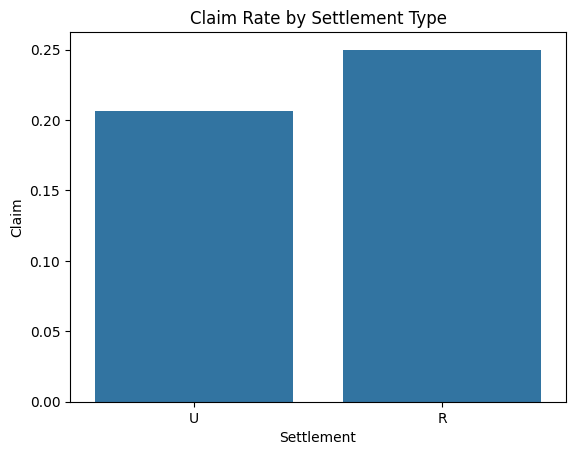

In [22]:
sns.barplot(x='Settlement',y='Claim', data=Insurance_data, estimator=np.mean, errorbar=None)
plt.title("Claim Rate by Settlement Type");


Insight: Buildings in settlement type 'R' have a slightly higher claim rate (approximately 25%) compared to buildings in settlement type 'U' (approximately 20.6%). This suggests that the settlement type 'R' might be associated with a higher likelihood of insurance claims.


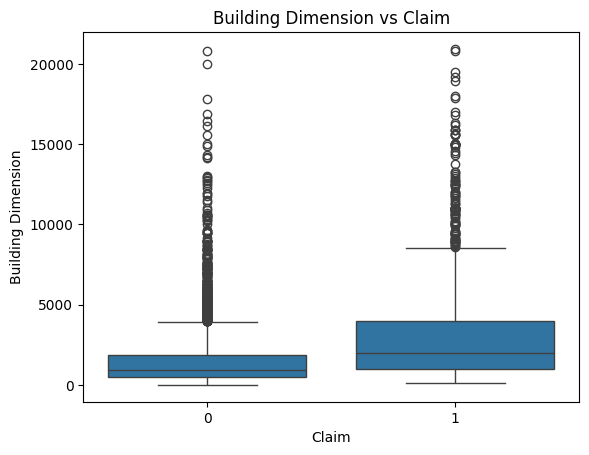

In [23]:
#Numerical feature vs claim
sns.boxplot(x='Claim', y='Building Dimension', data=Insurance_data)
plt.title("Building Dimension vs Claim");

In [24]:
display(Insurance_data.groupby('Claim')['Building Dimension'].describe())

,count,mean,std,min,25%,50%,75%,max
Claim,,,,,,,,
0,5526.0,1508.147666,1745.771948,1.0,480.25,915.5,1874.0,20818.0
1,1634.0,3101.951040,3191.186426,100.0,978.50,1987.5,4015.0,20940.0


Buildings with no claims (Claim = 0):

- The average (mean) building dimension is approximately 1508.15.
- The median (50th percentile) building dimension is 915.5.
- Most buildings without claims fall within dimensions from 480.25 (25th percentile) to 1874.0 (75th percentile).

Buildings with claims (Claim = 1):

- The average (mean) building dimension is significantly higher at approximately 3101.95.
- The median building dimension is also notably higher at 1987.5.
- Most buildings with claims have dimensions ranging from 978.50 (25th percentile) to 4015.0 (75th percentile).

This quantitative analysis confirms that properties involved in claims tend to have considerably larger 'Building Dimensions' on average and at their median compared to those without claims. This suggests that 'Building Dimension' could be an important factor in predicting insurance claims.

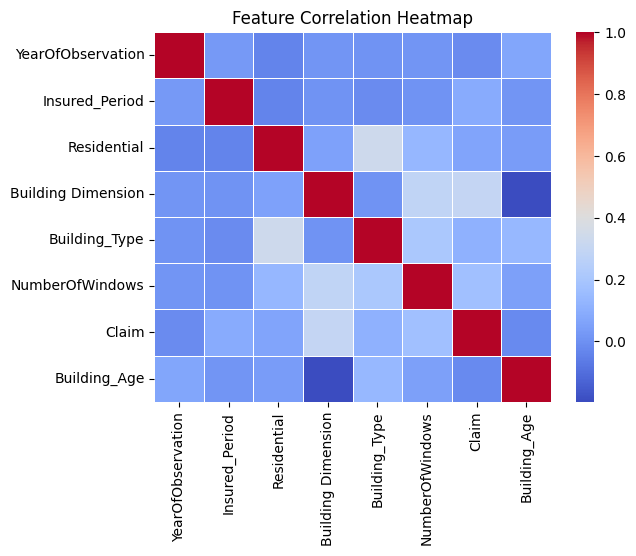

In [25]:
#Correlation analysis

numeric_cols = Insurance_data.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap");


Strongest Positive Correlation with Claim: The Building Dimension column shows the strongest positive correlation with Claim (0.24). This means that as the building dimension increases, the likelihood of a claim tends to increase.

Other Notable Correlations with Claim:
Residential has a small positive correlation (0.06) with Claim.
YearOfObservation and Insured_Period have very weak, almost negligible correlations with Claim.
NumberOfWindows and Building_Age also have weak positive correlations (0.05 and 0.05 respectively) with Claim.




##7. Data Preparation for Modelling

In [26]:
Insurance_data.tail()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim,Building_Age
7155,2012,1.000000,1,V,V,V,U,1083.0,1,4,6088,0,11
7156,2013,1.000000,0,V,V,V,U,1083.0,2,4,6088,1,33
7157,2016,0.038251,0,V,V,V,U,1083.0,1,4,6088,0,24
7158,2013,1.000000,0,V,V,V,U,1083.0,1,4,6088,0,41
7159,2014,1.000000,0,V,V,V,U,1083.0,1,4,6088,0,10


In [27]:
#Encode Categorical Variables

Insurance_data= pd.get_dummies(Insurance_data, columns= ['Building_Painted','Building_Fenced', 'Garden', 'Settlement'], drop_first=True)

In [28]:
# Check the number of unique values in 'Geo_Code'
unique_geo_codes = Insurance_data['Geo_Code'].nunique()
print(f"Number of unique Geo_Code values: {unique_geo_codes}")

Number of unique Geo_Code values: 1307


Geo code has very high cardinality  (many unique values) and no direct numerical meaning as it is not crucial for the prediction. One-hot encoding it would introduce sparsity and overfitting, so it was excluded from the model

In [29]:
# Seperate features from Target
x = Insurance_data.drop(columns=['Claim', 'Geo_Code'])
y = Insurance_data['Claim']

In [30]:
#Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
#8. Feature Scaling
# Scale only Continuous Columns

num_cols = ['YearOfObservation', 'Insured_Period', 'Building Dimension', 'NumberOfWindows', 'Building_Age']
scaler = StandardScaler()

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test_scaled[num_cols] = scaler.transform(x_test[num_cols])

##8. Model Building

In [32]:
# Model 1: Logistic Regression Model (Using Scaled data)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [33]:
y_pred_log = log_model.predict(x_test_scaled)

print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1105
           1       0.59      0.15      0.24       327

    accuracy                           0.78      1432
   macro avg       0.69      0.56      0.56      1432
weighted avg       0.75      0.78      0.73      1432



In [34]:
# Model 2: Using Random Forest (No scaling)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight= 'balanced')
rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1105
           1       0.47      0.27      0.34       327

    accuracy                           0.76      1432
   macro avg       0.64      0.59      0.60      1432
weighted avg       0.73      0.76      0.74      1432



In [35]:
#Model 3: Introducing HyperParameter Tuning to optimize my Random Forest Model for a better Recall since its ROC AUC score is okay
from sklearn.model_selection import GridSearchCV

In [36]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(x_train, y_train)

print (grid_search.best_params_)
print (grid_search.best_estimator_)


{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)


In [37]:
grid_prediction = grid_search.predict(x_test)
print(classification_report(y_test, grid_prediction))

              precision    recall  f1-score   support

           0       0.84      0.77      0.81      1105
           1       0.40      0.50      0.44       327

    accuracy                           0.71      1432
   macro avg       0.62      0.64      0.62      1432
weighted avg       0.74      0.71      0.72      1432



In [38]:
#Model 4: Training a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(x_train, y_train)

y_pred_gb = gb_model.predict(x_test)

print(classification_report(y_test, y_pred_gb))


              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.60      0.21      0.32       327

    accuracy                           0.79      1432
   macro avg       0.70      0.59      0.59      1432
weighted avg       0.76      0.79      0.75      1432



In [39]:
#Model 5: Training an XGBoost Classifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)

print('Classification Report for XGBoost Model:')
print(classification_report(y_test, y_pred_xgb))

Classification Report for XGBoost Model:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1105
           1       0.49      0.25      0.33       327

    accuracy                           0.77      1432
   macro avg       0.65      0.59      0.60      1432
weighted avg       0.73      0.77      0.74      1432



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:44:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 9. Model Evaluation

In [40]:
#ROC-AUC scores for each model
# Calculate the probability predictions for the positive class
y_prob_log= log_model.predict_proba(x_test_scaled)[:,1]
print("ROC AUC score for Logistic Regression:", roc_auc_score(y_test, y_prob_log))

y_prob_rf= rf_model.predict_proba(x_test)[:,1]
print("ROC AUC score for Random Forest Classifier:", roc_auc_score(y_test, y_prob_rf))

best_rf_model = grid_search.best_estimator_ #Get the best estimator from GridSearchCV
y_prob_optimized_rf = best_rf_model.predict_proba(x_test)[:,1]
roc_auc_optimized_rf = roc_auc_score(y_test, y_prob_optimized_rf)
print(f"ROC AUC score for Hyperparameter Optimized Random Forest Classifier: {roc_auc_optimized_rf}")

y_prob_gb = gb_model.predict_proba(x_test)[:, 1]
print('ROC AUC Score for Gradient Boosting Classifier:', roc_auc_score(y_test, y_prob_gb))

y_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]
print('ROC AUC Score for XGBoost Classifier:', roc_auc_score(y_test, y_prob_xgb))

ROC AUC score for Logistic Regression: 0.6936084243153859
ROC AUC score for Random Forest Classifier: 0.6563078583585868
ROC AUC score for Hyperparameter Optimized Random Forest Classifier: 0.694640707376811
ROC AUC Score for Gradient Boosting Classifier: 0.6914926591667012
ROC AUC Score for XGBoost Classifier: 0.6816942726278938


##**Model Performance Summary:**

**1. Logistic Regression (Scaled Data):**

ROC AUC: 0.6936

Class 0 (No Claim): Precision: 0.79, Recall: 0.97, F1-score: 0.87

Class 1 (Claim): Precision: 0.59, Recall: 0.15, F1-score: 0.24

Insight: High recall for no-claim, but very low recall for the claim class, meaning it misses most actual claims. Its ROC AUC is decent, but the poor recall on the minority class is a concern.

**2. Random Forest (Unoptimized, class_weight='balanced'):**

ROC AUC: 0.6563

Class 0 (No Claim): Precision: 0.81, Recall: 0.91, F1-score: 0.86

Class 1 (Claim): Precision: 0.47, Recall: 0.27, F1-score: 0.34

Insight: Better recall for the minority class than Logistic Regression, but still relatively low. The overall ROC AUC is lower than Logistic Regression.

**3. Hyperparameter Optimized Random Forest (max_depth=5, class_weight='balanced'):**

ROC AUC: 0.6946

Class 0 (No Claim): Precision: 0.84, Recall: 0.77, F1-score: 0.81

Class 1 (Claim): Precision: 0.40, Recall: 0.50, F1-score: 0.44

Insight: This model significantly improves recall for the minority class (Claim=1) to 0.50, which is the best among all models. However, this comes at the cost of precision for class 1 (0.40) and a slightly lower recall for class 0. It achieves the highest ROC AUC score.

**4. Gradient Boosting Classifier:**

ROC AUC: 0.6915

Class 0 (No Claim): Precision: 0.80, Recall: 0.96, F1-score: 0.87

Class 1 (Claim): Precision: 0.60, Recall: 0.21, F1-score: 0.32

Insight: Similar to Logistic Regression in terms of recall for the minority class (low) and ROC AUC. It has good precision for class 1 but struggles to identify a large portion of the actual claims.

**5. XGBoost Classifier:**

ROC AUC: 0.6817

Class 0 (No Claim): Precision: 0.81, Recall: 0.92, F1-score: 0.86

Class 1 (Claim): Precision: 0.49, Recall: 0.25, F1-score: 0.33

Insight: Similar to Random Forest, the metrics are still relatively low for the claim class. The overall ROC AUC is lower than Logistic Regression.

**Comparison and Recommendation:**

- **Best Overall Performance (considering Recall for Minority Class & ROC AUC):** The Hyperparameter Optimized Random Forest Classifier stands out. While its precision for class 1 is lower than some others, its recall of 0.50 for the 'Claim' class is significantly better, meaning it correctly identifies half of the actual claims. This is crucial for an imbalanced dataset where identifying the minority class is often the primary goal. It also boasts the highest ROC AUC score, indicating good discriminatory power.

- **Decision:** If the business objective is to identify as many potential claims as possible (high recall), even if it means some false positives, then the Hyperparameter Optimized Random Forest Classifier is the best choice among these models.

##10. Feature Importance (Random Forest)

In [41]:
feature_importance = pd.DataFrame({'Feature': x_train.columns, 'Importance': rf_model.feature_importances_})
feature_importance= feature_importance.sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
3,Building Dimension,0.467432
6,Building_Age,0.193789
1,Insured_Period,0.077191
0,YearOfObservation,0.074827
4,Building_Type,0.065319
5,NumberOfWindows,0.063260
2,Residential,0.025665
7,Building_Painted_V,0.018583
8,Building_Fenced_V,0.004719
10,Settlement_U,0.004632


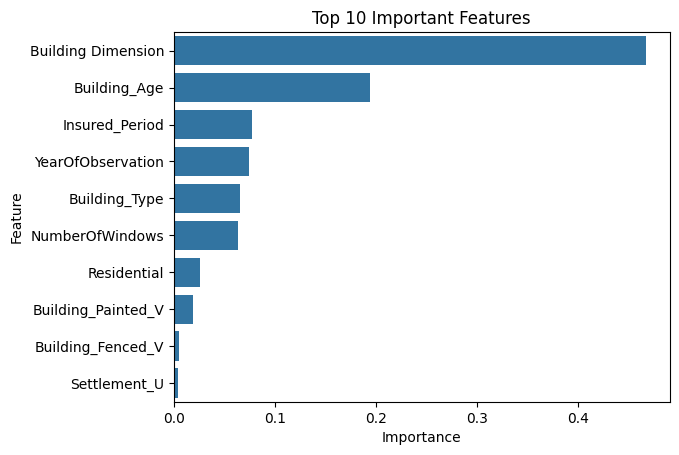

In [42]:
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), )
plt.title('Top 10 Important Features');

'Building Dimension' is an important factor in predicting 'insurance claims', followed by building age.

##11. Business Interpretation

**Key Insights**

- A greater number of the buildings have no claim

- Rural buildings (R) show slightly higher claim rates than Urban buildings (U)

- 'Building Dimension' is strongly positively correlated with claims

- Tree-based models outperform linear models

**Recommended Model**

- Hyperparameter Optimized Random Forest

It  has the best recall and ROC-AUC score which provides better probability ranking for insurance claims/decisions.